# 0. Setup

## Libraries

In [1]:
import geopandas as gpd
import folium
from branca.colormap import linear
from folium.plugins import GroupedLayerControl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
from matplotlib import cm
import seaborn as sns
from shapely.geometry import Point
import plotly.express as px

## Datasets

### Municipal Vote Dataset (2014 - 2022)

**Source**: [Vote per city](https://sig.tse.jus.br/ords/dwapr/seai/r/sig-eleicao-resultados/)  
**Description**:  
Contains official election results from the Brazilian presidential runoff in 2014, 2018 and 2022, aggregated at the municipality level.

Key columns:

- `nm_municipio`: City name  
- `nm_urna_candidato`: Candidate (e.g., Jair Bolsonaro, Lula)  
- `sg_partido`: Political party  
- `pc_votos_validos`: Proportion of valid votes for that candidate  
- `qt_votos_nom_validos`: Raw vote count  
- `nm_regiao`: Brazilian macro-region (e.g., NORTE, SUDESTE)

This dataset allowed us to assign vote direction (left or right) and analyze support patterns across geography and demographics.

In [2]:
vote_df = pd.read_csv('data/votacao_candidato-municipio_2022.csv')
vote_df.head()

,sg_uf,nm_municipio,nr_candidato,nm_urna_candidato,sg_partido,ds_sit_totalizacao,sg_ue,sq_candidato,nm_tipo_destinacao_votos,nm_regiao,pc_votos_validos,qt_votos_nom_validos,qt_votos_concorrentes
0,AC,ACRELÂNDIA,22,JAIR BOLSONARO,PL,Não Eleito,BR,280001618036,Válido,NORTE,0.7846,5317,6777
1,AC,ACRELÂNDIA,13,LULA,PT,Eleito,BR,280001607829,Válido,NORTE,0.2154,1460,6777
2,AC,ASSIS BRASIL,22,JAIR BOLSONARO,PL,Não Eleito,BR,280001618036,Válido,NORTE,0.5891,2717,4612
3,AC,ASSIS BRASIL,13,LULA,PT,Eleito,BR,280001607829,Válido,NORTE,0.4109,1895,4612
4,AC,BRASILÉIA,22,JAIR BOLSONARO,PL,Não Eleito,BR,280001618036,Válido,NORTE,0.7079,9593,13551


### Human Development Index (IDHM) per City
**Source**: [`Atlas Brasil](http://www.atlasbrasil.org.br/consulta/planilha)  
**Description**:  
This dataset provides municipality-level Human Development Index data for Brazil, broken down into components:

- `Overall IDHM`: Composite index (0 to 1), representing development level.  
- `IDHM Wage`: Economic indicator based on average income.  
- `IDHM Longevity`: Health component, linked to life expectancy.  
- `IDHM Education`: Education component, based on literacy and school attendance.

*Note: Values are scaled by 100 in the raw dataset and were later normalized to the 0–1 range for analysis.*

In [3]:
idh_df = pd.read_csv('data/idh.csv', header=0, sep=',')
state_df = gpd.read_file('data/state_2022.gpkg')
idh_df.head()

,Ranking,City (State),Overall IDHM,IDHM Wage,IDHM Longevity,IDHM Education
0,1 º,São Caetano do Sul (SP),862,891,887,811
1,2 º,Águas de São Pedro (SP),854,849,890,825
2,3 º,Florianópolis (SC),847,870,873,800
3,4 º,Balneário Camboriú (SC),845,854,894,789
4,4 º,Vitória (ES),845,876,855,805


## Ethinicity per City

### Municipal Vote Dataset (2014 - 2022)

**Source**: [Ethnicity proportion per city](https://basedosdados.org/dataset/08a1546e-251f-4546-9fe0-b1e6ab2b203d?table=ebd0f0fd-73f1-4295-848a-52666ad31757&utm_term=censo%20ibge%202022&utm_campaign=Trend+do+Censo+2022&utm_source=adwords&utm_medium=ppc&hsa_acc=9488864076&hsa_cam=21101952202&hsa_grp=160879691738&hsa_ad=693650899919&hsa_src=g&hsa_tgt=kwd-1414005611223&hsa_kw=censo%20ibge%202022&hsa_mt=b&hsa_net=adwords&hsa_ver=3&gad_source=1&gad_campaignid=21101952202&gbraid=0AAAAApsIj8yNL0gtaS3lxjLsif19SjYTv&gclid=CjwKCAjw24vBBhABEiwANFG7y-8uNUfz-8p9WAhx6K_rrdHc7GJYLRPF-DIldxt4kqvfQLHibUnszRoCOP8QAvD_BwE)  
**Description**:  
Contains the total amount of people per ethnicity per city
Key columns:

- `nm_municipio`: City name  
- `race`: Ethnicity (White, Black, Yellow, Indigenous, Brown)
- `name_state`: Brazilian State (e.g. SP, SC)
- `name_region`: Brazilian macro-region (e.g., NORTE, SUDESTE)

This dataset allowed us to assign vote direction (left or right) and analyze support patterns across geography and demographics.

## Welfare Social Program
**Source**: [Social Program per State](https://dados.gov.br/dados/conjuntos-dados/bolsa-familia---pagamentos)  
**Description**:  
Contains the total amount of people receiving the benefit per state
Key columns:

- `name_state`: Brazilian State (e.g. SP, SC)
- `Total_people`: Total Amount of people receiving the benefit

This dataset, that was already aggregated from the source allowed us to assign vote ideology (left or right) and analyze support patterns across social data.



# 1. Motivation

Brazil’s recent presidential elections have exposed deep and growing political, economic, and regional divides. As the country swung from a left-leaning government in the early 2000s to a far-right presidency in 2018—and back again in 2022—the political polarization has increasingly mirrored underlying socioeconomic structures. Understanding how geography, development, and migration patterns intersect with voting behavior is essential for grasping the forces shaping Brazil's political landscape.

Brazil holds presidential elections every four years, typically in two rounds. To be elected president, a candidate must receive more than half of the valid votes. If no candidate achieves this in the first round, the two with the most votes compete in a second round. The first round features a diverse range of political ideologies, but in recent years, the second round has usually involved candidates representing the left and right wings, and in this project we are focusing on second rounds of elections held in 2014, 2018 and 2022, because we find this race between right and left quite intersting.
Unlike the United States, where states award electoral votes and some votes carry more weight than others, Brazil uses a system in which each vote has the same value nationwide. Therefore, to win the election, a candidate must secure more than half of the total valid votes cast. More about Brazilian elections [here](https://en.wikipedia.org/wiki/Elections_in_Brazil).

The questions we want to answer are following. What type of cities influence the election results the most? Do cities with higher development levels tend to vote differently than those with lower HDI scores? Has the political lean of Brazilians living abroad changed over time? Are there consistent patterns between urban and rural municipalities? These are the types of questions this analysis seeks to answer.

Through a combination of spatial visualizations, temporal comparisons, and socioeconomic correlations, we aim to tell a data-driven story of Brazil’s elections that is both accessible to a general audience and grounded in rigorous analysis.

# 2. Basic Statistics

We haven't include any basic statistcis in this section, because of nature of our datasets. Instead, all data analysis is combined in data analysis section. 

## Data Cleaning and Preprocessing

Our analysis integrated multiple datasets, each requiring specific preparation steps to ensure compatibility and clarity, those where main focuspoints of preprocessing:

1. **Yearly Municipal Maps**  
   For each election year (2014, 2018, 2022), a pre-merged GeoPackage (`merged_YEAR.gpkg`) was loaded. These datasets already included the vote proportions and party information by municipality, enabling year-wise geospatial comparison.
2. **Standardization of IDH Values**  
   The IDHM values in the dataset were originally scaled by 100. Although the notebook didn't explicitly show normalization, this would typically be handled by dividing relevant columns (`IDHM`, `IDHM Educação`, etc.) by 100 to bring them into a 0–1 range for interpretability.

3. **State-Level GeoData Handling**  
   The `state_2022.gpkg` file was loaded into a `GeoDataFrame` to enable geographic plotting of state vote distributions. It included columns for left/right vote totals and proportions (`percentage_right`, `total_votes_right`, etc.).

4. **Ethnicity data**
   For the merge with vote, some nan data was needed to be deleted because of some incongruences between name of cities, which could have some 'typos' or were just written different. Since from the around 5000 rows(number of cities) around 40 had this issue, we decided to not handle manually, and just delete it. After this cleaning, calculations to get the proportion of ethinicity population per city was done.
5. **Welfare Social Program**
   The data was already aggregated per State from the source, so no main preprocessing was needed.


# 3. Data Analysis

The goal of this section is to find interesting insights about all the different data we had. Here we list some directions that we looked into

No method of Machine Learning was used

## 1. Geospatial Voting Patterns

We analyzed voting outcomes across municipalities and states using election data from 2014, 2018, and 2022. By plotting maps with diverging color gradients (red for left, blue for right), we visualized how different regions supported opposing candidates.

**Findings (see figure below):**
- The **North and Northeast** consistently leaned left, while the **South and Midwest** were strongholds for the right.
- The **Southeast**, especially São Paulo and Minas Gerais, appeared more competitive and influential in the overall result.
- Over time, political alignment became **more polarized geographically**, with fewer “swing” regions.

Text(0.5, 0.98, 'Results of Brazilian Presidential Elections years 2014-2022')

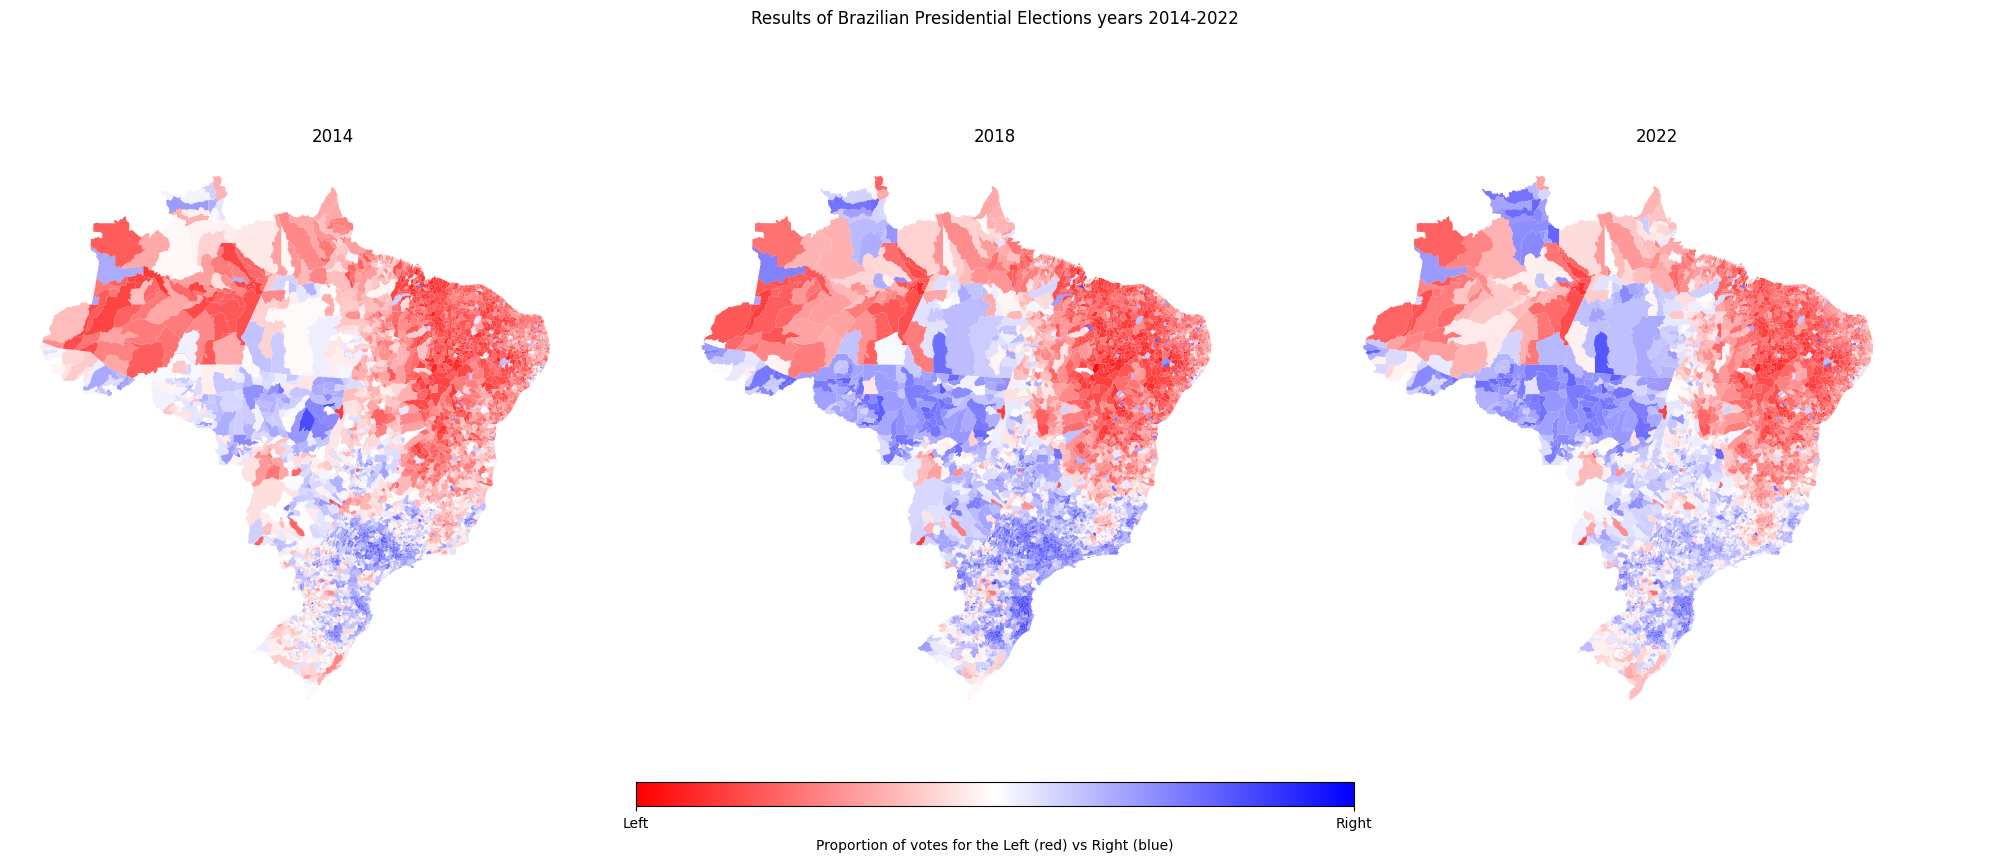

In [4]:
#Here is the map overview of election results
fig, ax = plt.subplots(1, 3, figsize=(20, 20 / 2.414))
gradient = True


norm = colors.Normalize(vmin=0, vmax=1)
cmap = plt.get_cmap("bwr")  

for i, year in enumerate([2014, 2018, 2022]):
    file = gpd.read_file(f"data/merged_{year}.gpkg")
    title = f"{year}"

    if gradient:
        file["color_grad"] = file.apply(
            lambda row: cmap(norm(row["pc_votos_validos"] if row["sg_partido"] == "PT" else 1 - row["pc_votos_validos"])),
            axis=1
        )
        file.plot(color=file["color_grad"], ax=ax[i])
    else:
        file.plot(color=file["color"], ax=ax[i])

    ax[i].set_title(title)
    ax[i].axis("off")


fig.tight_layout()

if gradient:
    sm = plt.cm.ScalarMappable(cmap=plt.get_cmap("bwr_r"), norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(
        sm,
        ax=ax,
        orientation="horizontal",
        fraction=0.03,
        pad=0.07,
        aspect=30,
    )
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels(["Left", "Right"])
    cbar.ax.tick_params(labelsize=10)
    cbar.set_label("Proportion of votes for the Left (red) vs Right (blue)", size=10, labelpad=6)

fig.suptitle("Results of Brazilian Presidential Elections years 2014-2022")


## 2. Histograms of percentage of vote distributions 

In order to see if there is connection between how different parts of Brazil tend to vote, we ploted histograms for three election results: in x axis fraction of voters voted right, and in y axis: for one set of histograms city friequency, and in other one city friequency is weighted by total voters of the city, which potentially could show soome interesting pattern.

Histogram is colured in the similar scale as in a figure above: blue for right voters (where fraction is more than 0.5) and red for the left.

**Findings (see figure below):**
- The distribution of percentage of right voters per city/municipality showed that there is a big difference between 2014 and two elections after that. There is no clear pattern in 2014, whereas both 2018 and 2022 have a bimodal distribution. There is significatly higher amount of municipalities which vote either around 75% left or around 75% right, and less for the ones that voted 50-50.
- The second set of histograms shows very high peak, very heavy weighted city/cities in around of 8-9 million voters. And the largest sity of Brazil in terms of voters is San Paulo with under 7 mil. Therefore this peak is a commulative of few cities, which is shown in year 2018, when it is divided into two peaks. It is interesting, that through out the years, it keeps going more and more left, which means on constant prograssion of lefft popularity in large cities. 
- This section inspired us to conduct analysis on City Type and Rate of Political switch. 

In [5]:

right_data = []
#for transforming presidents into right/left
ideology_map = {
    "AÉCIO NEVES": "right",
    "DILMA": "left",
    "JAIR BOLSONARO": "right",
    "FERNANDO HADDAD": "left",
    "LULA": "left",
}
for year in [2014, 2018, 2022]:
    data = pd.read_csv(f'data/votacao_candidato-municipio_{year}.csv')
    data = data.rename(columns={'sg_uf': 'state', "nm_municipio": "city", "nm_urna_candidato": "candidate", "pc_votos_validos": "percentage", 'qt_votos_nom_validos': 'num of votes'})
    data["ideology"] = data["candidate"].map(ideology_map)
    data['total voters'] = (data['num of votes'] / data['percentage'].astype(float)).round()
    data = data[["city", "ideology", "percentage", 'total voters', 'state']]
    data['year'] = year
    data = data[data['ideology']=='right']
    
    right_data.append(data)

right_data = pd.concat(right_data, ignore_index=True)
right_data.head(2)

,city,ideology,percentage,total voters,state,year
0,ACRELÂNDIA,right,0.6484,6286.0,AC,2014
1,ASSIS BRASIL,right,0.5184,4082.0,AC,2014


/tmp/ipykernel_26032/1459299609.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("bwr_r")


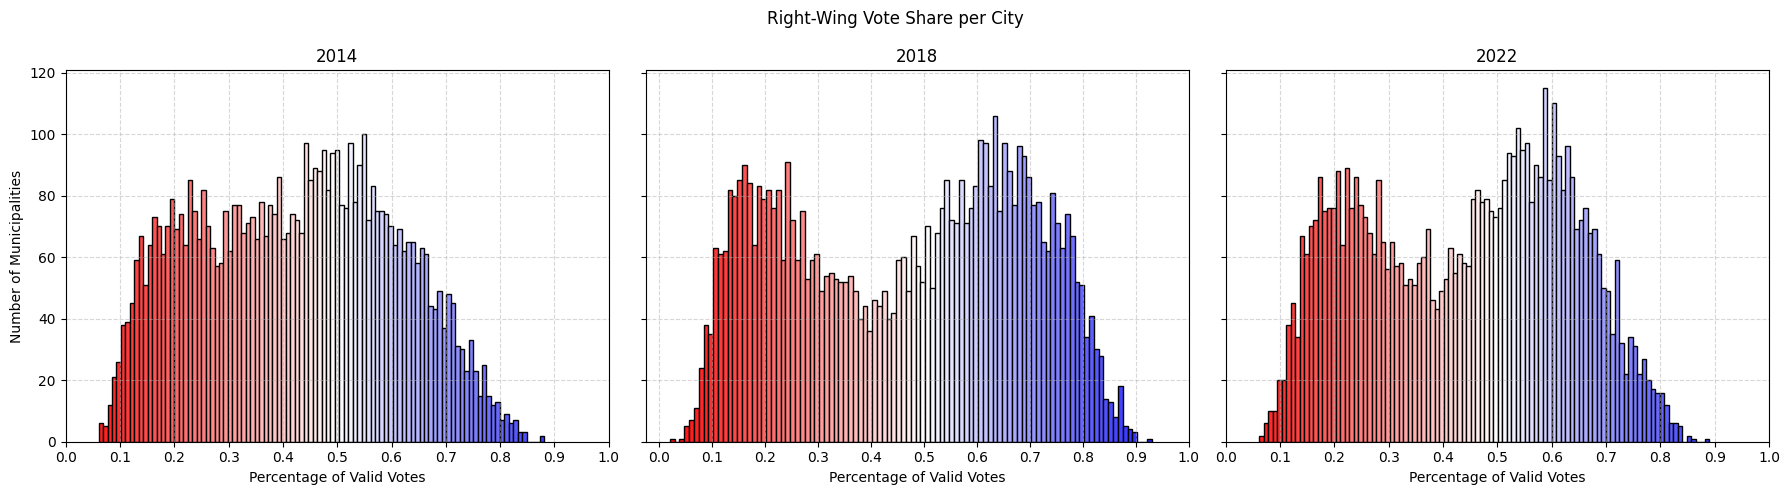

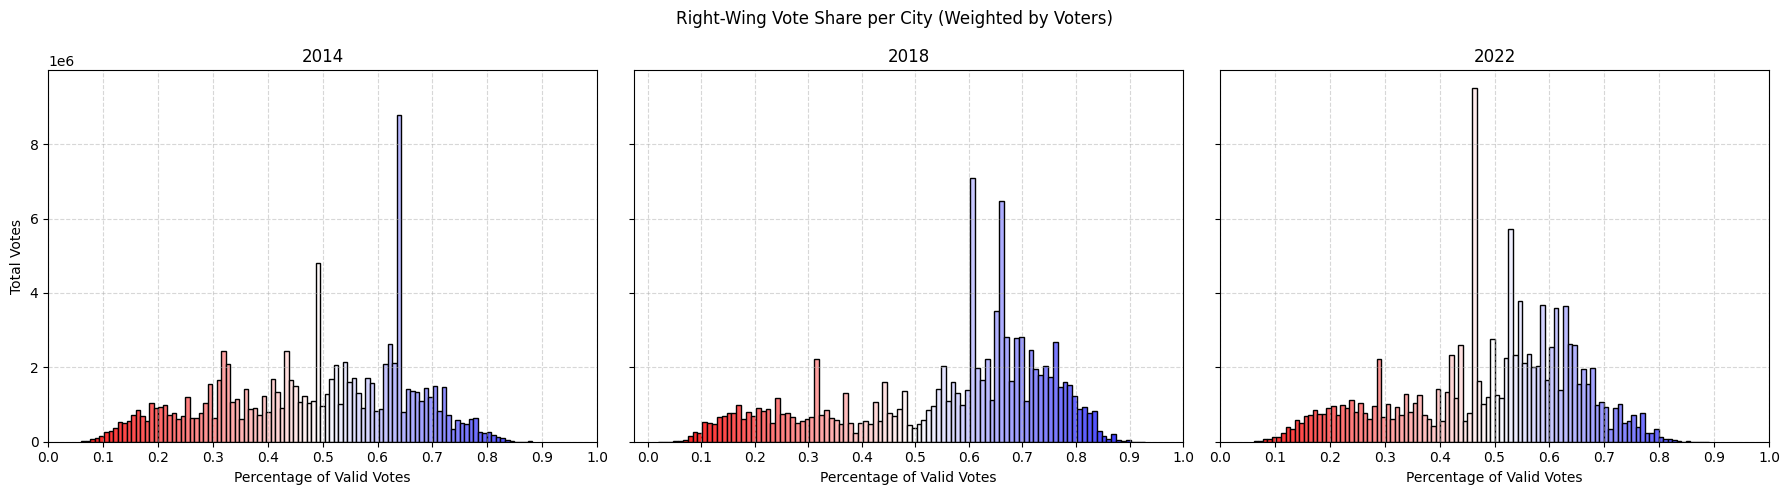

In [6]:
n_bins = 100
cmap = cm.get_cmap("bwr_r")

# First plot: number of municipalities
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for i, year in enumerate([2014, 2018, 2022]):
    ax = axes[i]
    data_year = right_data[right_data["year"] == year]
    values = data_year["percentage"]
    
    counts, bins = np.histogram(values, bins=n_bins)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    norm = np.clip(bin_centers, 0, 1)
    colors = cmap(norm)

    for j in range(n_bins):
        ax.bar(bin_centers[j], counts[j], width=(bins[1] - bins[0]), color=colors[j], edgecolor="black")

    ax.set_title(year)
    ax.set_xlabel("Percentage of Valid Votes")
    ax.set_xticks(np.linspace(0, 1, 11))
    ax.grid(True, linestyle="--", alpha=0.5)

axes[0].set_ylabel("Number of Municipalities")
fig.suptitle("Right-Wing Vote Share per City")
plt.subplots_adjust(top=0.85)
plt.tight_layout()
plt.show()

# Second plot: weighted by total voters
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for i, year in enumerate([2014, 2018, 2022]):
    ax = axes[i]
    data_year = right_data[right_data["year"] == year]

    counts, bins = np.histogram(data_year["percentage"], bins=n_bins, weights=data_year["total voters"])
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    norm = np.clip(bin_centers, 0, 1)
    colors = cmap(norm)

    for j in range(n_bins):
        ax.bar(bin_centers[j], counts[j], width=(bins[1] - bins[0]), color=colors[j], edgecolor="black")

    ax.set_title(year)
    ax.set_xlabel("Percentage of Valid Votes")
    ax.set_xticks(np.linspace(0, 1, 11))
    ax.grid(True, linestyle="--", alpha=0.5)

axes[0].set_ylabel("Total Votes")
fig.suptitle("Right-Wing Vote Share per City (Weighted by Voters)")
plt.subplots_adjust(top=0.85)
plt.tight_layout()

## 3. Analysis per states of Brazil 

Here our main idea was to see states that vote right the most and see if this correlates to their size.  Therefore we have plotted the barchart, with different year results next to each other. Also we ordered the states by the percentage of right voters of 2022

**Key insight:**
- Top three states of right supporters are very small. And the largest states are in the middle of the ordered list, meaning that those are neither high supporters of right nor blue
- We haven't proceed with analysis on the state level in this domain, largely because of time constraint.


/tmp/ipykernel_26032/3197208490.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  total_votes = right_data.groupby(["year", "state"]).apply(
/tmp/ipykernel_26032/3197208490.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  right_votes["state"] = pd.Categorical(right_votes["state"], categories=sorted_states, ordered=True)


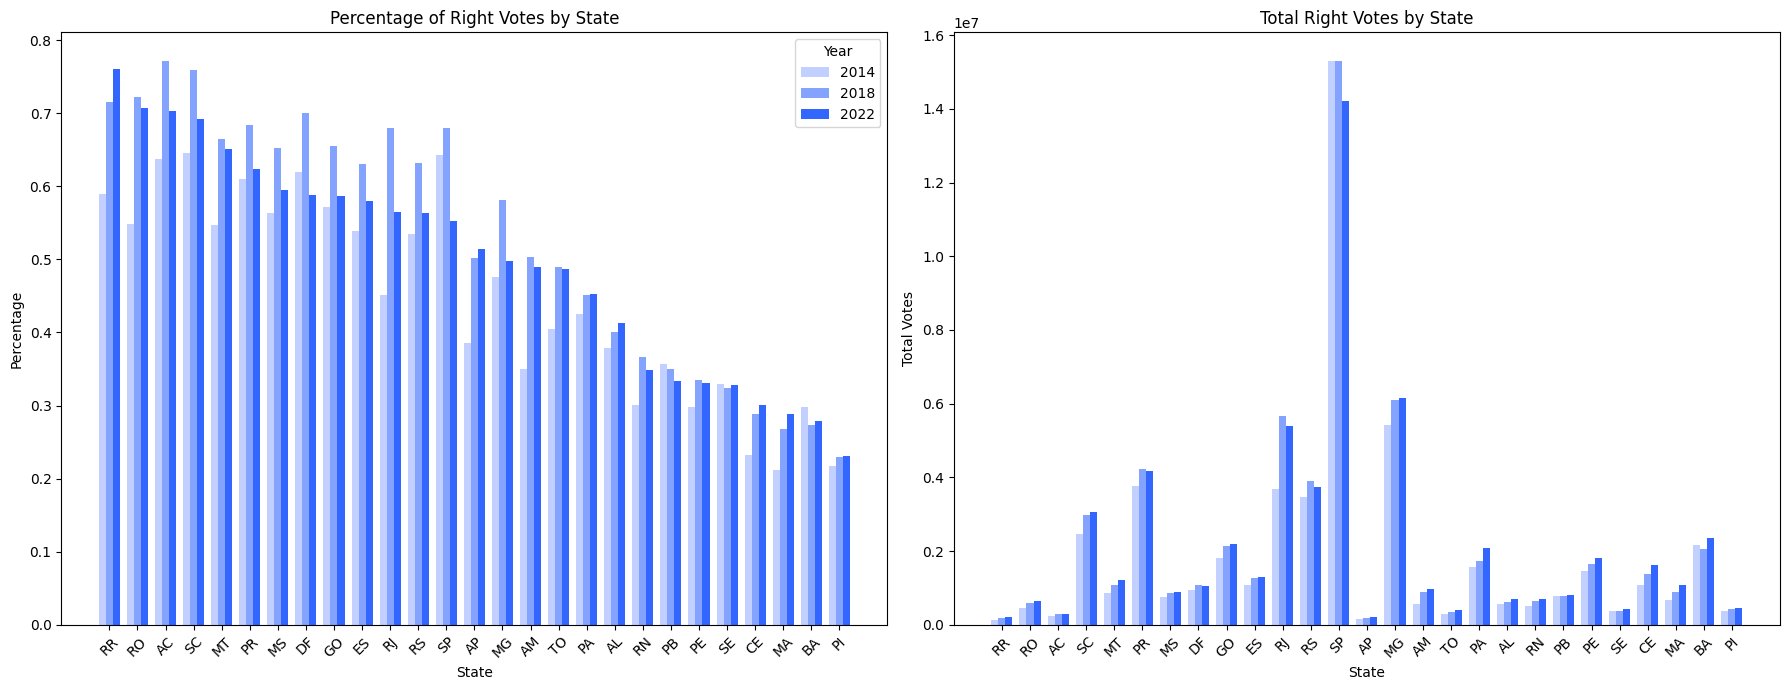

In [7]:
total_votes = right_data.groupby(["year", "state"]).apply(
    lambda x: pd.Series({
        "total_votes_right": (x["percentage"] * x["total voters"]).sum(),
        "total_votes_left": ((1 - x["percentage"]) * x["total voters"]).sum()
    })
).reset_index()

total_votes["percentage_right"] = total_votes["total_votes_right"] / (total_votes["total_votes_right"] + total_votes["total_votes_left"])
total_votes.to_csv("data/state_elections.csv", index=False)

right_votes = total_votes[["year", "state", "percentage_right", "total_votes_right"]]
sorted_states = right_votes[right_votes["year"] == 2022].sort_values("percentage_right", ascending=False)["state"].tolist()
right_votes["state"] = pd.Categorical(right_votes["state"], categories=sorted_states, ordered=True)
right_votes = right_votes.sort_values(["state", "year"])

years = sorted(right_votes["year"].unique())
x = np.arange(len(sorted_states))
width = 0.25
alphas = {y: a for y, a in zip(years, [0.3, 0.6, 1.0])}
colors = {y: (0.2, 0.4, 1.0, alphas[y]) for y in years}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7), sharex=True)
for i, year in enumerate(years):
    data = right_votes[right_votes["year"] == year]
    offset = x + i * width - width
    ax1.bar(offset, data["percentage_right"], width=width, label=str(year), color=colors[year])
    ax2.bar(offset, data["total_votes_right"], width=width, label=str(year), color=colors[year])

for ax, title, ylabel in zip((ax1, ax2), ["Percentage of Right Votes by State", "Total Right Votes by State"], ["Percentage", "Total Votes"]):
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel("State")
    ax.set_xticks(x)
    ax.set_xticklabels(sorted_states, rotation=45)

ax1.legend(title="Year")
plt.tight_layout()


In [8]:
idh_df = pd.read_csv('data/idh.csv', header=0, sep=',')
state_df = gpd.read_file('data/state_2022.gpkg')


## 4. HDI and Voting Direction

We merged HDI data with municipal voting data and grouped results by political direction (`left` or `right`). The Human Development Index (HDI) — particularly its education and income components — showed strong correlation with vote choice.

**Key insight:**
- Municipalities with **higher HDI** were significantly more likely to vote **right**, while those with **lower HDI** favored the **left**.
- This trend persisted across all three elections and appeared most distinct in 2022.

We visualized this using boxplots and density plots, confirming a **socioeconomic divide** in electoral behavior.

### HDI

In [9]:
idh_df.columns = ['Index','City', 'Overall', 'Income', 'Longevity', 'Education']  # Replace with actual column names
idh_df.drop(columns=['Index'], inplace=True)  # Drop the index column if not needed

for col in ['Overall', 'Income', 'Longevity', 'Education']:
    idh_df[col] = '0.' + idh_df[col].astype(str)
    idh_df[col] = idh_df[col].astype(float)

idh_df[['City', 'State']] = idh_df['City'].str.extract(r'^(.*)\s\((.*)\)$')

idh_df['City'] = idh_df['City'].str.strip()
idh_df['State'] = idh_df['State'].str.strip()

idh_df['City'] = idh_df['City'].str.upper()

### Vote

In [10]:
def combine_datasets(*dataframes):
    """
    Combine multiple DataFrames by stacking their rows.
    Parameters:
        *dataframes: A variable number of DataFrames to combine.
    Returns:
        A single DataFrame with all rows combined.
    """
    combined_df = pd.concat(dataframes, ignore_index=True)
    return combined_df

df_2014 = pd.read_csv('data/votacao_candidato-municipio_2014_2.csv')
df_2014['year'] = 2014
df_2018 = pd.read_csv('data/votacao_candidato-municipio_2018_2.csv')
df_2018['year'] = 2018
df_2022 = pd.read_csv('data/votacao_candidato-municipio_2022_2.csv')
df_2022['year'] = 2022
combined_votes_df = combine_datasets(df_2014, df_2018, df_2022)

def process_votes_data(df):
    df['direction'] = df['nm_candidato'].map({
        'JAIR MESSIAS BOLSONARO': 'right',
        'LUIZ INÁCIO LULA DA SILVA': 'left',
        'FERNANDO HADDAD': 'left',
        'AÉCIO NEVES DA CUNHA': 'right',
        'DILMA VANA ROUSSEFF': 'left'
    })
    df = df[df['ds_cargo'] == 'Presidente']
    df = df[df['sg_uf'] != 'ZZ']
    return df
votes_df = process_votes_data(combined_votes_df)
result = votes_df.loc[
    votes_df.groupby(['sg_uf', 'nm_municipio', 'year'])['pc_votos_validos'].idxmax()
]
result = result[['sg_uf', 'nm_municipio', 'direction', 'pc_votos_validos', 'year']]
merged_df_test = pd.merge(result, idh_df, left_on=['nm_municipio', 'sg_uf'], right_on=['City', 'State'], how='left')
nan_values = merged_df_test.isna()
rows_with_nan = merged_df_test[nan_values.any(axis=1)]
merged_df = pd.merge(result, idh_df, left_on=['nm_municipio', 'sg_uf'], right_on=['City', 'State'], how='inner')
corr_df = merged_df[['sg_uf', 'nm_municipio', 'year', 'Overall', 'direction',]]

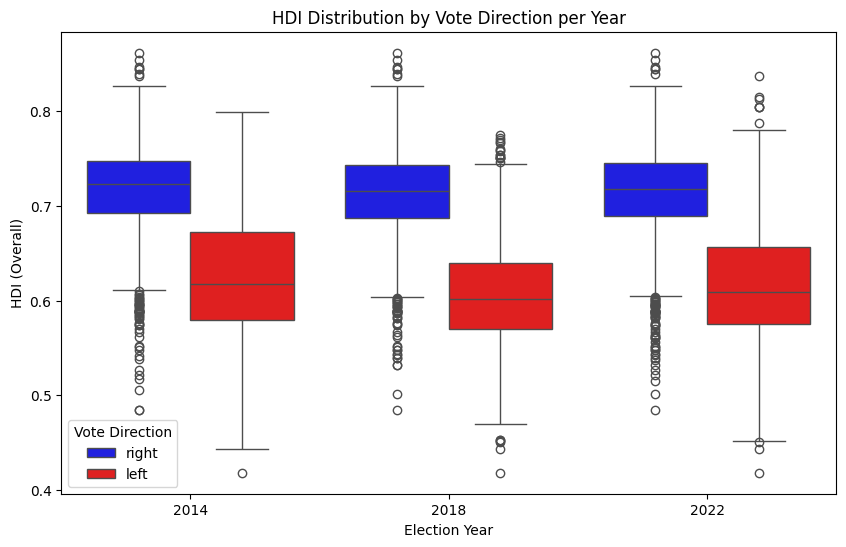

In [11]:

# Custom color palette: match "left" to red and "right" to blue
custom_palette = {
    'left': '#ff0000',
    'right': '#0000ff'
}

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=corr_df,
    x='year',
    y='Overall',
    hue='direction',
    palette=custom_palette
)
plt.title('HDI Distribution by Vote Direction per Year')
plt.ylabel('HDI (Overall)')
plt.xlabel('Election Year')
plt.legend(title='Vote Direction')
plt.savefig('outputs/hdi_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Diaspora Voting Analysis

Using city-level vote data from Brazilians abroad, we visualized voting outcomes in major foreign cities. The results showed:
- A notable **shift toward the left** among diaspora voters in 2022.
- European and North American cities were especially likely to swing left between 2018 and 2022.

In [12]:
def process_votes_data_zz(df):
    # Map values in the 'nm_urna_candidato' column
    df['direction'] = df['nm_candidato'].map({
        'JAIR MESSIAS BOLSONARO': 'right',
        'LUIZ INÁCIO LULA DA SILVA': 'left',
        'FERNANDO HADDAD': 'left',
        'AÉCIO NEVES DA CUNHA': 'right',
        'DILMA VANA ROUSSEFF': 'left'
    })
    
    # Filter rows for 'Presidente' and exclude 'ZZ' in 'sg_uf'
    df = df[df['ds_cargo'] == 'Presidente']
    df = df[df['sg_uf'] == 'ZZ']
    
    
    return df

votes_df_zz = process_votes_data_zz(combined_votes_df)

# Mapping of city names to countries
city_country_mapping = {
    'ABIDJÃ': 'Ivory Coast',
    'ABU DHABI': 'United Arab Emirates',
    'AMÃ': 'Jordan',
    'ANCARA': 'Turkey',
    'ARTIGAS': 'Uruguay',
    'ASSUNÇÃO': 'Paraguay',
    'ATENAS': 'Greece',
    'ATLANTA': 'United States',
    'BANGKOK': 'Thailand',
    'BARCELONA': 'Spain',
    'BEIRUTE': 'Lebanon',
    'BELGRADO': 'Serbia',
    'BERLIM': 'Germany',
    'BISSAU': 'Guinea-Bissau',
    'BOGOTÁ': 'Colombia',
    'BOSTON': 'United States',
    'BRUXELAS': 'Belgium',
    'BUCARESTE': 'Romania',
    'BUDAPESTE': 'Hungary',
    'BUENOS AIRES': 'Argentina',
    'CAIENA': 'French Guiana',
    'CAIRO': 'Egypt',
    'CAMBERRA': 'Australia',
    'CARACAS': 'Venezuela',
    'CHICAGO': 'United States',
    'CIDADE DO CABO': 'South Africa',
    'CIUDAD DEL ESTE': 'Paraguay',
    'CIUDAD GUAYANA': 'Venezuela',
    'COCHABAMBA': 'Bolivia',
    'CONCEPCIÓN': 'Chile',
    'COPENHAGUE-DINA': 'Denmark',
    'CÓRDOBA': 'Argentina',
    'DACAR': 'Senegal',
    'DOHA': 'Qatar',
    'DUBLIN': 'Ireland',
    'DÍLI': 'East Timor',
    'ENCARNACIÓN': 'Paraguay',
    'ESTOCOLMO': 'Sweden',
    'FARO': 'Portugal',
    'FRANKFURT': 'Germany',
    'GENEBRA': 'Switzerland',
    'GEORGETOWN': 'Guyana',
    'GUATEMALA-GUAT': 'Guatemala',
    'HAMAMATSU': 'Japan',
    'HARTFORD': 'United States',
    'HAVANA': 'Cuba',
    'HELSINQUE': 'Finland',
    'HONG KONG-HONG': 'Hong Kong',
    'HOUSTON': 'United States',
    'ISTAMBUL': 'Turkey',
    'JACARTA': 'Indonesia',
    'KINGSTON-JAMA': 'Jamaica',
    'KINSHASA': 'Democratic Republic of the Congo',
    'KUAITE': 'Kuwait',
    'KUALA LUMPUR': 'Malaysia',
    'LA PAZ': 'Bolivia',
    'LAGOS': 'Nigeria',
    'LIMA': 'Peru',
    'LISBOA': 'Portugal',
    'LIUBLIANA': 'Slovenia',
    'LONDRES': 'United Kingdom',
    'LOS ANGELES': 'United States',
    'LUANDA': 'Angola',
    'MADRI': 'Spain',
    'MANILA': 'Philippines',
    'MANÁGUA': 'Nicaragua',
    'MAPUTO': 'Mozambique',
    'MENDOZA': 'Argentina',
    'MIAMI': 'United States',
    'MILÃO': 'Italy',
    'MITSUKAIDO-JAPA': 'Japan',
    'MONTEVIDÉU': 'Uruguay',
    'MONTREAL': 'Canada',
    'MOSCOU': 'Russia',
    'MUNIQUE': 'Germany',
    'MÉXICO-MEXI': 'Mexico',
    'NAGÓIA': 'Japan',
    'NAIRÓBI': 'Kenya',
    'NICOSIA': 'Cyprus',
    'NOVA DELHI': 'India',
    'NOVA YORK': 'United States',
    'OIZUMI-JAPA': 'Japan',
    'OSLO': 'Norway',
    'OTTAWA': 'Canada',
    'PANAMÁ-PAN': 'Panama',
    'PARAMARIBO': 'Suriname',
    'PARIS': 'France',
    'PEDRO JUAN CABALLERO': 'Paraguay',
    'PEQUIM': 'China',
    'PORT OF SPAIN': 'Trinidad and Tobago',
    'PORTO': 'Portugal',
    'PORTO PRÍNCIPE': 'Haiti',
    'PRAGA': 'Czech Republic',
    'PRAIA': 'Cape Verde',
    'PRETÓRIA': 'South Africa',
    'QUITO': 'Ecuador',
    'RABAT': 'Morocco',
    'RAMALLAH-PALE': 'Palestine',
    'RIADE': 'Saudi Arabia',
    'ROMA': 'Italy',
    'ROTTERDÃ': 'Netherlands',
    'SALTO DEL GUAIRÁ': 'Paraguay',
    'SANTIAGO': 'Chile',
    'SEUL': 'South Korea',
    'SINGAPURA-SING': 'Singapore',
    'STA C LA SIERRA-BOLI': 'Bolivia',
    'SUZUKA-JAPA': 'Japan',
    'SYDNEY': 'Australia',
    'SÃO DOMINGOS': 'Dominican Republic',
    'SÃO FRANCISCO': 'United States',
    'SÃO JOSÉ': 'Costa Rica',
    'SÃO SALVADOR': 'El Salvador',
    'TAIPÉ': 'Taiwan',
    'TAKAOKA-JAPA': 'Japan',
    'TEERÃ': 'Iran',
    'TEGUCIGALPA': 'Honduras',
    'TEL AVIV': 'Israel',
    'TORONTO': 'Canada',
    'TOYOHASHI-JAPA': 'Japan',
    'TUNIS': 'Tunisia',
    'TÓQUIO': 'Japan',
    'UEDA-JAPA': 'Japan',
    'VANCOUVER': 'Canada',
    'VARSÓVIA': 'Poland',
    'VIENA': 'Austria',
    'WASHINGTON': 'United States',
    'WELLINGTON': 'New Zealand',
    'WINDHOEK': 'Namibia',
    'XANGAI': 'China',
    'ZAGREB': 'Croatia',
    'ZURIQUE': 'Switzerland',
    'ACCRA-GANA': 'Ghana',
    'BRATISLAVA': 'Slovakia',
    'CANTÃO': 'China',
    'CHUY': 'Uruguay',
    'DAR ES SALAAM': 'Tanzania',
    'GUATEMALA': 'Guatemala',
    'HANÓI': 'Vietnam',
    'KATMANDU': 'Nepal',
    'KIEV': 'Ukraine',
    'KINGSTON-JAMAICA': 'Jamaica',
    'LUSACA': 'Zambia',
    'MASCATE': 'Oman',
    'NASSAU': 'Bahamas',
    'RIO BRANCO': 'Brazil',
    'TALIN': 'Estonia',
    'ABUJA': 'Nigeria',
    'ACCRA': 'Ghana',
    'ADIS ABEBA': 'Ethiopia',
    'AMSTERDÃ': 'Netherlands',
    'ARGEL': 'Algeria',
    'ASTANA': 'Kazakhstan',
    'BAGDÁ': 'Iraq',
    'BAKU': 'Azerbaijan',
    'BAMAKO': 'Mali',
    'BAREIN': 'Bahrain',
    'BELMOPAN': 'Belize',
    'BRAZZAVILLE': 'Republic of the Congo',
    'BRIDGETOWN': 'Barbados',
    'CASTRIES': 'Saint Lucia',
    'COBIJA': 'Bolivia',
    'COLOMBO': 'Sri Lanka',
    'CONACRI': 'Guinea',
    'COPENHAGUE': 'Denmark',
    'COTONOU': 'Benin',
    'DAMASCO': 'Syria',
    'GABORONE': 'Botswana',
    'HARARE': 'Zimbabwe',
    'HONG KONG': 'Hong Kong',
    'IAUNDÊ': 'Cameroon',
    'IEREVAN': 'Armenia',
    'IQUITOS': 'Peru',
    'ISLAMABADE': 'Pakistan',
    'LIBREVILLE': 'Gabon',
    'LILONGUE': 'Malawi',
    'LOMÉ': 'Togo',
    'MALABO': 'Equatorial Guinea',
    'MEXICO': 'Mexico',
    'MUMBAI': 'India',
    'PANAMA': 'Panama',
    'PASO LOS LIBRES': 'Argentina',
    'PUERTO IGUAZÚ': 'Argentina',
    'PUERTO QUIJARRO': 'Bolivia',
    'RAMALLAH': 'Palestine',
    'RIVERA': 'Uruguay',
    'SAINT JOHNS': 'Antigua and Barbuda',
    'SANTA CRUZ DE LA SIERRA': 'Bolivia',
    'SARAJEVO': 'Bosnia and Herzegovina',
    'SINGAPURA': 'Singapore',
    'ST GEORGES DE LOYAPOCK': 'French Guiana',
    'SÃO TOMÉ': 'São Tomé and Príncipe',
    'SÓFIA': 'Bulgaria',
    'TBILISI': 'Georgia',
    'TIRANA': 'Albania',
    'TRÍPOLI': 'Libya',
    'UAGADUGU': 'Burkina Faso',
    'VATICANO': 'Vatican City',
    'YANGON': 'Myanmar'
}


votes_df_zz['country'] = votes_df_zz['nm_municipio'].map(city_country_mapping)

votes_df_zz_plot = votes_df_zz[['country', 'direction', 'nm_municipio', 'year', 'pc_votos_validos']]
votes_df_zz_plot = votes_df_zz_plot.dropna()

# Group by 'sg_uf' and 'nm_municipio', and find the row with the maximum 'pc_votos_validos'
result_zz = votes_df_zz_plot.loc[
    votes_df_zz_plot.groupby(['country', 'nm_municipio', 'year'])['pc_votos_validos'].idxmax()
]

# Select only the relevant columns
result_zz = result_zz[['country', 'nm_municipio', 'direction', 'pc_votos_validos', 'year']]

# Display the result_zz
# result_zz.head()

# import pandas as pd
# from geopy.geocoders import Nominatim
# import time

# # Your DataFrame
# # df = pd.read_csv("your_data.csv")  # or already loaded

# geolocator = Nominatim(user_agent="city_mapper")

# def get_location(row):
#     try:
#         location = geolocator.geocode(f"{row['nm_municipio']}, {row['country']}")
#         time.sleep(1)  # to respect usage limits
#         if location:
#             return pd.Series([location.latitude, location.longitude])
#     except:
#         return pd.Series([None, None])

# result_zz[['lat', 'lon']] = result_zz.apply(get_location, axis=1)

# result_zz.to_csv('result_zz.csv', index=False)

result_zz = pd.read_csv('data/result_zz.csv')
# result_zz.head()

winner_df = result_zz.groupby(['nm_municipio', 'country', 'year', 'lat', 'lon'])['direction'] \
                     .agg(lambda x: x.value_counts().idxmax()).reset_index()

## 6. Ethinicity Dataset

In [13]:
file_2014 = gpd.read_file("data/merged_2014_v1.gpkg")
file_2018 = gpd.read_file("data/merged_2018_v1.gpkg")
file_2022 = gpd.read_file("data/merged_2022_v1.gpkg")

file_2014['year'] = 2014
file_2018['year'] = 2018
file_2022['year'] = 2022

full_df = gpd.GeoDataFrame(pd.concat([file_2014, file_2018, file_2022], ignore_index=True))
full_df.to_file("data/merged_all_years.gpkg", driver="GPKG")

# full_df['year'].value_counts()

ideology_map = {
    "AÉCIO NEVES": "right",
    "DILMA": "left",
    "JAIR BOLSONARO": "right",
    "FERNANDO HADDAD": "left",
    "LULA": "left",
}

full_df['direction'] = full_df['nm_urna_candidato'].map(ideology_map)

race_cols = ['Branca', 'Preta', 'Parda', 'Amarela', 'Indígena']

# Convert race columns to numeric (coerce errors to NaN)
for col in race_cols:
    full_df[col] = pd.to_numeric(full_df[col], errors='coerce')

full_df['race_total'] = full_df[race_cols].sum(axis=1)

# Create percentage columns
for col in race_cols:
    full_df[f'{col}_pct'] = full_df[col] / full_df['race_total']

corr_results = []

for (year, direction), group in full_df.groupby(['year', 'direction']):
    for race in race_cols:
        pct_col = f'{race}_pct'
        if pct_col in group.columns:
            corr = group[pct_col].corr(group['qt_votos_concorrentes'])
            corr_results.append({
                'year': year,
                'direction': direction,
                'race': race,
                'correlation': corr
            })

corr_df = pd.DataFrame(corr_results)

fig = px.bar(
    corr_df,                     # The correlation table we created
    x="race",
    y="correlation",
    color="direction",
    barmode="group",
    facet_col="year",
    category_orders={"year": sorted(corr_df["year"].unique())},
    title="Correlation between Race and Vote Count by Year and Direction",
    height=500
)

fig.update_layout(yaxis_title="Pearson Correlation", xaxis_title="Race Group")
fig.write_html("race_correlation_plot.html", auto_open=True)


race_rename = {
    'Branca': 'White',
    'Preta': 'Black',
    'Parda': 'Brown',
    'Amarela': 'Asian',
    'Indígena': 'Indigenous'
}

full_df.rename(columns=race_rename, inplace=True)

# Also rename the % columns
pct_rename = {f"{k}_pct": f"{v}_pct" for k, v in race_rename.items()}
full_df.rename(columns=pct_rename, inplace=True)

# Define which race columns count as "minority"
minority_cols = ['Black_pct', 'Indigenous_pct']

# Calculate the combined minority percentage
full_df['Minority_pct'] = full_df[minority_cols].sum(axis=1)

## 7. Welfare brazilian Social Program

In [14]:
df_bolsa_familia = pd.read_csv("data/bolsa_familia.csv")
df_pop_uf = pd.read_csv("data/brazil_population_by_state.csv")

df_pop_uf.rename(columns={"Unidade Federativa": "UF"}, inplace=True)

df_merged = pd.merge(df_bolsa_familia, df_pop_uf, on="UF", how="inner")

df_merged['families_per_1000'] = df_merged['Famílias Contempladas'] / df_merged['População 2024'] * 100

df_merged.sort_values(by="families_per_1000", ascending=False, inplace=True)


# Dictionary mapping full state names to 2-letter codes
uf_to_code = {
    'Acre': 'AC', 'Alagoas': 'AL', 'Amapá': 'AP', 'Amazonas': 'AM', 'Bahia': 'BA',
    'Ceará': 'CE', 'Distrito Federal': 'DF', 'Espírito Santo': 'ES', 'Goiás': 'GO',
    'Maranhão': 'MA', 'Mato Grosso': 'MT', 'Mato Grosso do Sul': 'MS', 'Minas Gerais': 'MG',
    'Pará': 'PA', 'Paraíba': 'PB', 'Paraná': 'PR', 'Pernambuco': 'PE', 'Piauí': 'PI',
    'Rio de Janeiro': 'RJ', 'Rio Grande do Norte': 'RN', 'Rio Grande do Sul': 'RS',
    'Rondônia': 'RO', 'Roraima': 'RR', 'Santa Catarina': 'SC', 'São Paulo': 'SP',
    'Sergipe': 'SE', 'Tocantins': 'TO'
}

# Create a new column with the state codes
df_merged["UF_code"] = df_merged["UF"].map(uf_to_code)

fig = px.choropleth(
    df_merged,
    geojson="https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson",
    locations="UF_code",
    featureidkey="properties.sigla",
    color="families_per_1000",
    color_continuous_scale=px.colors.sequential.Hot[::-1],  # Reverse for heatmap effect
    scope="south america",
    title="Households Benefiting by State (Brazil)"
)

fig.update_geos(fitbounds="locations", visible=False)
fig.show()
fig.write_html("assets/bolsa_familia_map.html", auto_open=True)

# 4. Genre


Whole section is based on information from Segel, E., & Heer, J. (2010)

We decided to adopt a magazine-style genre with elements from other genres to tell our story. This format was a natural choice because we needed to support our visualizations with substantial textual messaging. Some of our visualizations—such as a dashboard comparing city types—align more closely with the partitioned poster genre, which enhances a reader-driven experience.

A potential issue with our approach is that it still imposes a relatively strict order in which the reader must follow the story. This is particularly problematic because some parts of the narrative are not strongly connected and could be rearranged without losing meaning. To address this, we introduced interactive elements—such as interactive maps and radio buttons for selecting the year—to provide more flexibility and engagement.

**Visual Narrative tools** 
- Visual structuring:
    - Establishing Shots. Each section begins with a clear headline and context-setting paragraph before the visual (e.g., "Who won in each city?", "HDI and Vote".
    - Consistent layout. All visualizations follow a consistent layout with map-based or chart-based sections embedded in a scrolling story. This helped users stay oriented
- Highlighting: mainly by introducting big questions in captions, using consistent blue/ red colours
- Transition guidance: familiar objects - we used native checkboxes for iteractive map, and simple radio buttons for dasboard. This contributes to intuitivity of transitions (but of course takes away asthetical value of the ) 

**Visual Structure tools** 
- Ordering: User directed path as mentioned earlier, the magazine genre, or in our case it looks like online article
- Interactivity: even thoug we don't have it in all figures, our maps have filtering (by year) and zooming
- Messaging: we have introduction and summary elemnets, as well as our captions are in form of questions, which the vizuals are answering

# 5. Visualization

here we describe how visualizations of our website alonakonst.github.io where done

## City Type and Rate of Political switch

The idea of this vizualizations was to show a relationship of city size and the rate of change or influence on the final outcome of the results. 

For this purpose we decided to go with 8 categories of cities (this was done by Chatgpt, but it correlates with sources online) and classified cities based on number of total voters. We have neglected not voted part of the population. 

In [15]:
bins = [500, 2500, 20000, 100000, 250000, 500000, 1_000_000, 5_000_000, float("inf")]
labels = [
    "Village", "Small Town", "Medium Town", "Large Town / Small City",
    "Medium City", "Large City", "Metropolis", "Megalopolis"
]

right_data["city_size"] = pd.cut(
    right_data["total voters"],
    bins=bins,
    labels=labels,
    right=False  
)

In [16]:
#uniform palete for city type colouring: 

city_size_order = [
    "Village", "Small Town", "Medium Town", "Large Town / Small City",
    "Medium City", "Large City", "Metropolis", "Megalopolis"
]
palette = sns.color_palette("Set2", n_colors=len(city_size_order))
palette_dict = dict(zip(city_size_order, palette))

We also had to add some rate of change of percentage/fraction of right voters, it is calculated as follows:

In [17]:
filtered = right_data[right_data["year"].isin([2014, 2018, 2022])]

pivoted = filtered.pivot_table(
    index=["city", "state"],
    columns="year",
    values="percentage"
).reset_index()

pivoted = pivoted.rename(columns={2014: "percentage_2014", 2018: "percentage_2018", 2022: "percentage_2022"})

pivoted["perc_diff_2014_vs_2018"] = (pivoted["percentage_2018"] - pivoted["percentage_2014"])
pivoted["perc_diff_2018_vs_2022"] = (pivoted["percentage_2022"] - pivoted["percentage_2018"])

right_data = pd.merge(
    right_data,
    pivoted[["city", "state", "perc_diff_2014_vs_2018", "perc_diff_2018_vs_2022"]],
    on=["city", "state"],
    how="left"
)
right_data.head(2)

,city,ideology,percentage,total voters,state,year,city_size,perc_diff_2014_vs_2018,perc_diff_2018_vs_2022
0,ACRELÂNDIA,right,0.6484,6286.0,AC,2014,Small Town,0.1505,-0.0143
1,ASSIS BRASIL,right,0.5184,4082.0,AC,2014,Small Town,0.0659,0.0048


First vizualization is scater plot, in order for a user to see a correlation between, rate of change (difference in right voter fraction between two elections 2014->2018 and 2018->2022. Since in case of cities we have to handle wide ranges, logarithmic scale is used.


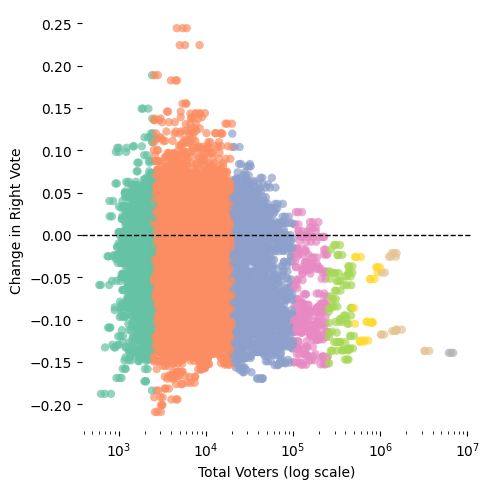

In [18]:
import matplotlib.ticker as ticker
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(
    data=right_data,
    x="total voters",
    y="perc_diff_2018_vs_2022", # or  y="perc_diff_2014_vs_2018",
    hue="city_size",
    palette=palette_dict,
    edgecolor="none",
    ax=axes,
    alpha=0.7
)

axes.set_xscale("log")
axes.set_xlabel("Total Voters (log scale)")
axes.set_ylabel("Change in Right Vote")

axes.axhline(0, color="black", linestyle="--", linewidth=1)

for spine in axes.spines.values():
    spine.set_visible(False)

axes.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))  

axes.legend([], frameon=False)

plt.tight_layout()
plt.show()

Next vizualization is bar charts: avarage switch in percentage fot different city types.

/tmp/ipykernel_26032/1005708186.py:4: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.


/tmp/ipykernel_26032/1005708186.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




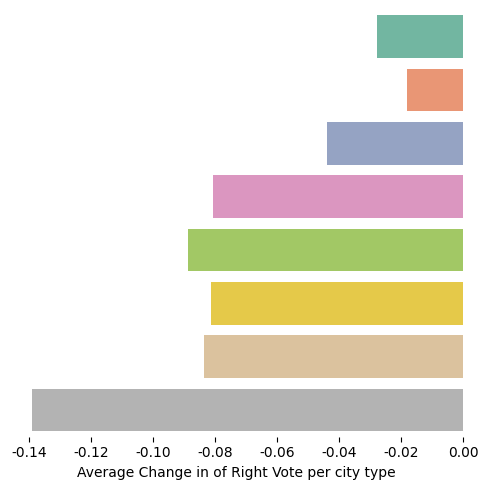

In [19]:
from matplotlib.ticker import FuncFormatter
fig, ax = plt.subplots(figsize=(5, 5))
sns.set_style("white")
sns.barplot(
    data=right_data,
    y="city_size",
    x="perc_diff_2018_vs_2022",
    palette=palette_dict,
    ax=ax,
    edgecolor="none",
    ci=None, 
    linewidth=0
)

ax.set_yticklabels([])  
ax.yaxis.set_ticks_position('none')  
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_xlabel("Average Change in of Right Vote per city type")
ax.set_ylabel("")  
ax.grid(False)

ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.2f}"))

plt.tight_layout()
plt.show()


And finally, donut chart is a good selection of vizualizing percentual influence into shift of power.

In [20]:
#this is how influence is computed
influence = right_data.groupby(["year", "city_size"]).agg({
    "total voters": "sum",
    "perc_diff_2014_vs_2018": lambda x: x.abs().mean(),
    "perc_diff_2018_vs_2022": lambda x: x.abs().mean()
}).reset_index()

influence['influence_2018'] = influence['total voters'] * influence['perc_diff_2014_vs_2018']
influence['influence_2022'] = influence['total voters'] * influence['perc_diff_2018_vs_2022']

influence_2018 = influence[influence['year'] == 2018]
influence_2022 = influence[influence['year'] == 2022]

/tmp/ipykernel_26032/1421624955.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



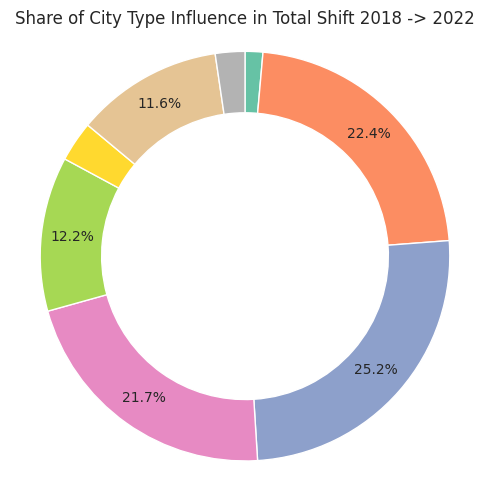

In [21]:
def autopct_func(pct):
    return f"{pct:.1f}%" if pct > 5 else ""
    
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
axes.pie(
    influence_2018['influence_2018'], #influence_2022['influence_2022']
    colors=[palette_dict[cs] for cs in influence["city_size"]],
    autopct=autopct_func,
    startangle=90,
    counterclock=False,
    wedgeprops={"width": 0.3},
          
    pctdistance=0.85          
)

ax.text(0, 0, "2014–2018", fontsize=12, fontweight='bold', ha='center', va='center')

axes.set_title("Share of City Type Influence in Total Shift 2018 -> 2022")

axes.axis("equal")  

plt.tight_layout()
plt.savefig("right_vote_shift_donut.png", dpi=600, bbox_inches='tight')
plt.show()

This is followed by combining those three figures in Figma and exported as png together with a legend.

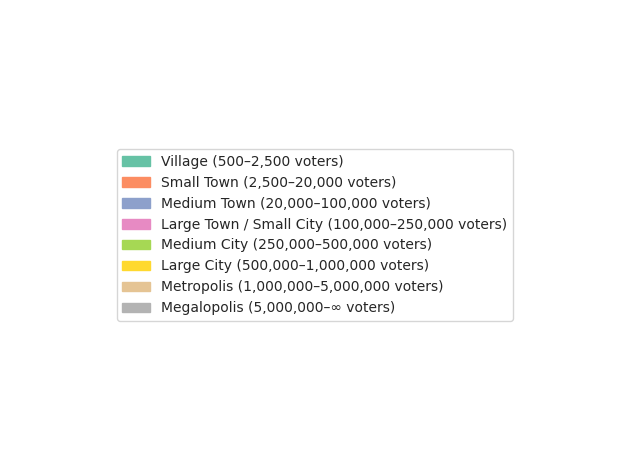

In [22]:
import matplotlib.patches as mpatches

custom_labels = []
for i, label in enumerate(labels):
    lower = f"{int(bins[i]):,}"
    upper = "∞" if bins[i+1] == float("inf") else f"{int(bins[i+1]):,}"
    custom_labels.append(f"{label} ({lower}–{upper} voters)")


legend_handles = [
    mpatches.Patch(color=palette_dict[label], label=custom_labels[i])
    for i, label in enumerate(labels)
]

fig, ax = plt.subplots()
ax.axis('off')
for spine in ax.spines.values():
    spine.set_visible(False)

ax.legend(handles=legend_handles, loc='center')

plt.tight_layout()
plt.savefig("legend.png", dpi=600, bbox_inches='tight')
plt.show()


This was we resulted in multiple plot vizualization of City Type and Rate of Political switch

## HDI (Human Development Index) vs Votes per City

The idea of this visualization is to show if there is any correlation by the HDI from a city with their preferred political party or ideology. It was possible to see for all the years that cities with a lower HDI overall tends to vote more towards left. 

But it was also possible to notice that the amount of cities with higher HDI preferring right decreased from 2018 to 2022.

A combination of histogram with line chart and showing how it changed for every election year it was the best visualization that the group found to show the change comparison. Also, it was decided to use three visualizations, instead of applying a filter in order to be able to do this comparison quickly.

KeyError: "None of [Index(['Overall'], dtype='object')] are in the [columns]"

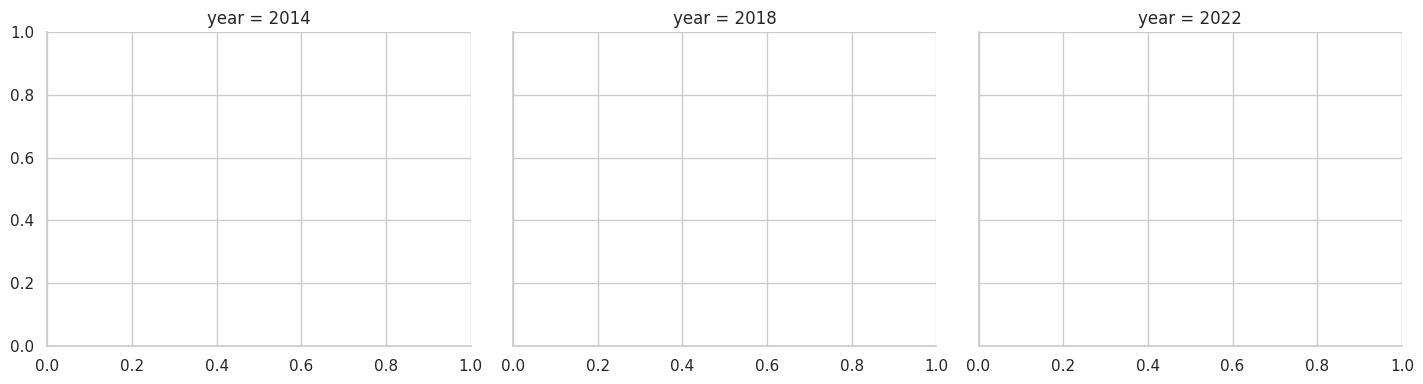

[GFX1-]: RenderCompositorSWGL failed mapping default framebuffer, no dt


In [ ]:
sns.set(style="whitegrid")

# Create FacetGrid to show a histogram for each year
g = sns.FacetGrid(corr_df, col="year", hue="direction", palette={'left': '#ff0000', 'right': '#0000ff'}, height=4, aspect=1.2)
g.map(sns.histplot, "Overall", bins=30, kde=True, alpha=0.6)
g.add_legend(title="Vote Direction")

g.set_axis_labels("HDI (Overall)", "Count")
g.fig.suptitle("HDI Distribution by Vote Ideology per Year", y=1.05)

plt.savefig('outputs/HDI_Distribution.png')
plt.show()

## Votes from emigrated population

It would be interesting to understand as well from the people who left the country, how were their political preferences.

The map plot with dots representing the left and right was the best choice in order to visualize how distributed was around the world the votes from people who emigrated. Also, it would help to find some regional trend, for example, people who emigrated to Europe looks have a more similiar vote than people who emigrated to US or other countries from South America.

It was possible to notice that the votes towards left increased for people who left the country

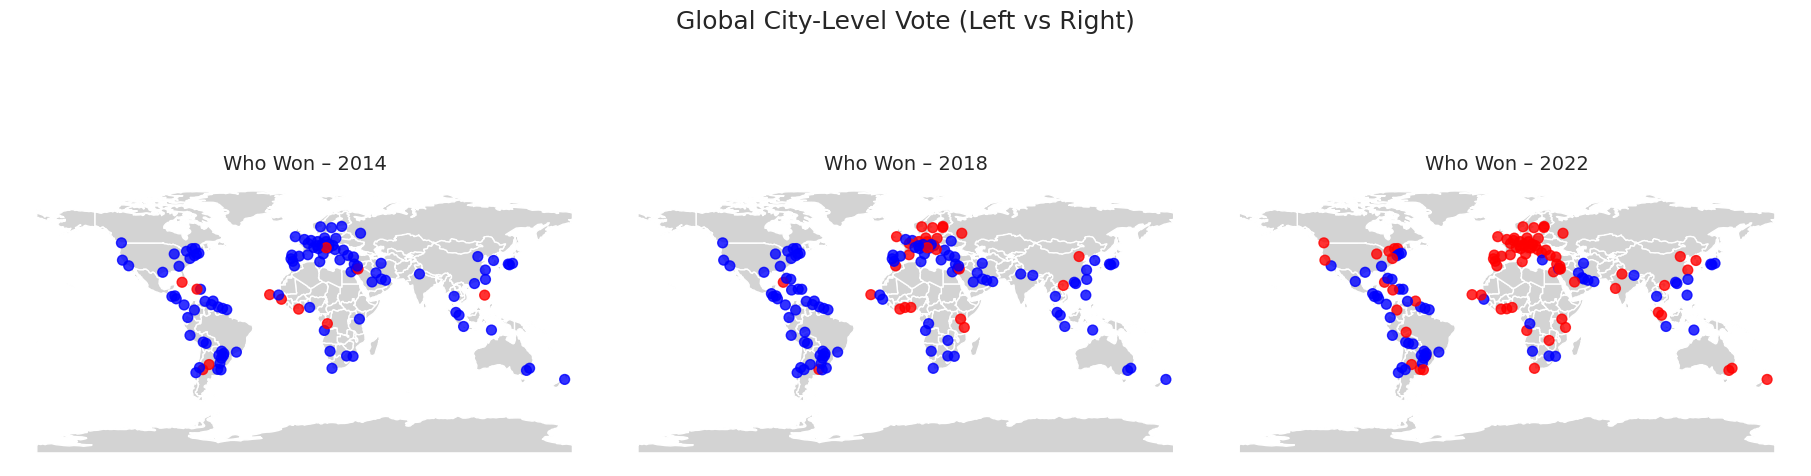

In [ ]:
# Load base map
world = gpd.read_file('/home/paulobeckhauser/Documents/dtu/social_data/finalAssignment/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')

# Convert your DataFrame to GeoDataFrame
geometry = [Point(xy) for xy in zip(result_zz['lon'], result_zz['lat'])]
gdf = gpd.GeoDataFrame(result_zz, geometry=geometry, crs="EPSG:4326")

# Colors for directions
direction_colors = {'left': 'red', 'right': 'blue'}

# Plot one map per year
years = gdf['year'].unique()
fig, axes = plt.subplots(1, len(years), figsize=(6 * len(years), 6), constrained_layout=True)

for ax, year in zip(axes, sorted(years)):
    world.plot(ax=ax, color='lightgrey', edgecolor='white')
    year_data = gdf[gdf['year'] == year]
    year_data.plot(ax=ax,
                   color=year_data['direction'].map(direction_colors),
                   markersize=50, alpha=0.8)
    ax.set_title(f"Who Won – {year}", fontsize=14)
    ax.axis('off')

plt.suptitle("Global City-Level Vote (Left vs Right)", fontsize=18)
plt.savefig('outputs/global_vote_direction.png', dpi=300)
plt.show()

## Interactive Plot (City and State)

### State

In [ ]:
def election_layer_state(year: int, gdf: gpd.GeoDataFrame) -> folium.FeatureGroup:
    fg = folium.FeatureGroup(
        name=str(year),
        show=(year == 2022),
        control=True,
    )

    cmap = linear.RdBu_11.scale(0, 1).to_step(12)

    def style_fn(feature):
        row = gdf.iloc[int(feature["id"])]
        pct = row["percentage_right"]
        return {
            "fillColor": cmap(pct),
            "color": "black",
            "weight": 0.3,
            "fillOpacity": 0.7,
        }

    tooltip = folium.GeoJsonTooltip(
        fields=[
            "state",
            "percentage_right",
        ],
        aliases=[
            "State",
            "% votes",
        ],
        sticky=True,
    )

    folium.GeoJson(gdf, tooltip=tooltip, style_function=style_fn).add_to(fg)

    return fg

In [ ]:
def make_multi_year_map(
    outfile="elections_state.html",
):
    probe_gdf = gpd.read_file("data/state_2022.gpkg").to_crs(4326)
    minx, miny, maxx, maxy = probe_gdf.total_bounds
    brazil_bounds = [[miny, minx], [maxy, maxx]]
    centre = [(miny + maxy) / 2, (minx + maxx) / 2]

    m = folium.Map(
        location=centre,
        zoom_start=5,  # initial rough zoom
        tiles="CartoDB positron",
        control_scale=True,
        max_bounds=True,  # users cannot pan outside brazil_bounds
    )
    m.fit_bounds(brazil_bounds)

    KEEP = [
        "geometry",
        "state",
        "percentage_right",
    ]

    overlay_groups = []
    for yr in [2014, 2018, 2022]:
        gdf = (
            gpd.read_file(f"data/state_{yr}.gpkg")
            .to_crs(4326)
            .reset_index(drop=False)
            .rename(columns={"index": "id"})[KEEP]
        )
        gdf["geometry"] = gdf["geometry"].simplify(
            0.02,
            preserve_topology=True,
        )
        fg = election_layer_state(yr, gdf)
        fg.add_to(m)
        overlay_groups.append(fg)

    GroupedLayerControl(
        groups={"Election year": overlay_groups},
        exclusive_groups=True,
        collapsed=False,
    ).add_to(m)

    overlay_groups[-1].add_to(m)

    colourbar = linear.RdBu_11.scale(0, 1).to_step(12)
    colourbar.caption = "Left ← vote share → Right"
    colourbar.position = "bottomleft"
    colourbar.add_to(m)

    m.save(outfile)
    return outfile

In [ ]:
path = make_multi_year_map()
# print(f"wrote: {path}")

### City

In [ ]:
def election_layer_city(year: int, gdf: gpd.GeoDataFrame) -> folium.FeatureGroup:
    fg = folium.FeatureGroup(
        name=str(year),
        show=(year == 2022),
        control=True,
    )

    cmap = linear.RdBu_11.scale(0, 1).to_step(12)

    def style_fn(feature):
        row = gdf.iloc[int(feature["id"])]
        pct = row["pc_votos_validos"] / 100.0
        value = pct if row["sg_partido"] == "PT" else 1 - pct
        return {
            "fillColor": cmap(value),
            "color": "black",
            "weight": 0.3,
            "fillOpacity": 0.7,
        }

    tooltip = folium.GeoJsonTooltip(
        fields=[
            "nm_municipio",
            "sg_uf",
            "sg_partido",
            "pc_votos_validos",
        ],
        aliases=[
            "Municipality",
            "State",
            "Winner party",
            "% votes",
        ],
        sticky=True,
    )

    folium.GeoJson(gdf, tooltip=tooltip, style_function=style_fn).add_to(fg)

    return fg

In [ ]:
def make_multi_year_map(
    outfile="elections_br.html",
):
    # 1. Use the first year’s layer to get Brazil’s bounding box
    probe_gdf = gpd.read_file("data/merged_2022.gpkg").to_crs(4326)
    minx, miny, maxx, maxy = probe_gdf.total_bounds
    brazil_bounds = [[miny, minx], [maxy, maxx]]
    centre = [(miny + maxy) / 2, (minx + maxx) / 2]

    # 2. Make the base map, locked to Brazil
    m = folium.Map(
        location=centre,
        zoom_start=5,  # initial rough zoom
        tiles="CartoDB positron",
        control_scale=True,
        max_bounds=True,  # users cannot pan outside brazil_bounds
    )
    m.fit_bounds(brazil_bounds)

    KEEP = [
        "geometry",
        "sg_partido",
        "pc_votos_validos",
        "nm_municipio",
        "sg_uf",
    ]

    # 3. Add election layers
    overlay_groups = []
    for yr in [2014, 2018, 2022]:
        gdf = (
            gpd.read_file(f"data/merged_{yr}.gpkg")
            .to_crs(4326)
            .reset_index(drop=False)
            .rename(columns={"index": "id"})[KEEP]
        )
        gdf["geometry"] = gdf["geometry"].simplify(
            0.02,
            preserve_topology=True,
        )
        fg = election_layer_city(yr, gdf)
        fg.add_to(m)
        overlay_groups.append(fg)

    # 4. Radio-button picker
    GroupedLayerControl(
        groups={"Election year": overlay_groups},
        exclusive_groups=True,
        collapsed=False,
    ).add_to(m)

    overlay_groups[-1].add_to(m)

    # 5. One shared colour bar
    colourbar = linear.RdBu_11.scale(0, 1).to_step(12)
    colourbar.caption = "Left ← vote share → Right"
    colourbar.position = "bottomleft"
    colourbar.add_to(m)

    m.save("elections_br.html")
    return outfile

In [ ]:
path = make_multi_year_map()
# print(f"wrote: {path}")

wrote: elections_br.html


## Ethnicity

Also, we could get some information about how is distributed the ethnicity per city and then see how this it can be related to the votes.

The Ministry of Racial Equality from Brazil defines that currently the Black and Indigenous population represents what they call the "Social Minority", even if they can not be minority in terms of population size.

We want to go deep and check if depending of the ethnicity of a person in Brazil, and mainly the minorities, if they vote for some specific ideology.

We have found that on average, the minority population vote more towards left, which have been increasing in the last elections.

We believe that a Bar plot comparing these proportions during the years, would be the best to have this comparison, even that a scatterplot was also explored.

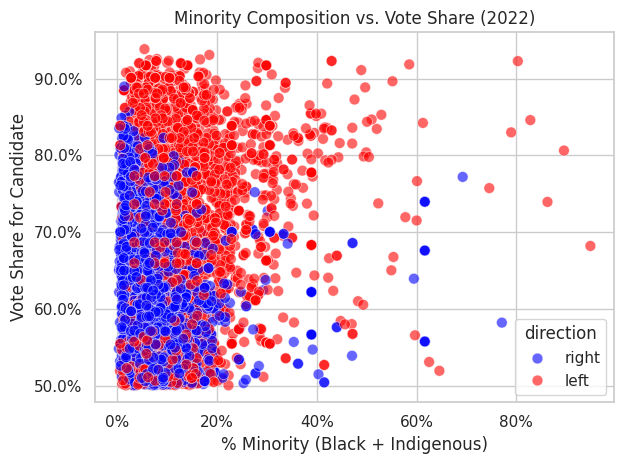

In [ ]:
import matplotlib.ticker as mtick

palette = {
    "left":  "#FF0000",   # red
    "right": "#0000FF"    # blue
}

sns.scatterplot(
    data  = full_df[full_df["year"] == 2022],
    x     = "Minority_pct",
    y     = "pc_votos_validos",
    hue   = "direction",
    palette = palette,        # <-- custom colours
    alpha   = 0.6,
    s       = 60,             # marker size
    edgecolor = "white",      # thin white outline
    linewidth = 0.5
)
plt.title("Minority Composition vs. Vote Share (2022)")
plt.xlabel("% Minority (Black + Indigenous)")
plt.ylabel("Vote Share for Candidate")

# format both axes as %
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))   # 0 – 1 scale
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.tight_layout()
plt.savefig("assets/minority_composition_vs_vote_share.png",
            dpi=300, bbox_inches="tight")
plt.show()

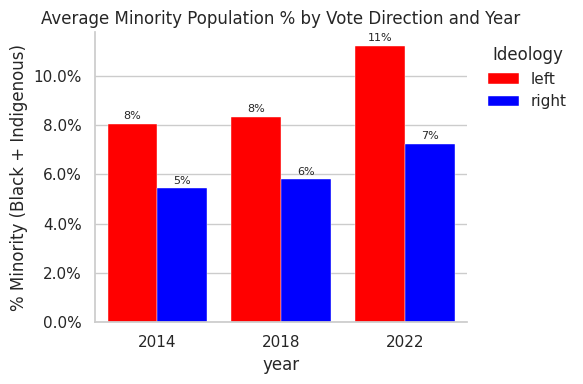

In [25]:
import matplotlib.ticker as mtick

avg_minority = (
    full_df
    .groupby(['year', 'direction'], as_index=False)['Minority_pct']
    .mean()
)

hue_order = ["left", "right"]                
palette   = {"left": "#FF0000",              
             "right": "#0000FF"}           


fig, ax = plt.subplots(figsize=(6, 4))
fig.subplots_adjust(right=0.82)

sns.barplot(
    data       = avg_minority,
    x          = "year",
    y          = "Minority_pct",
    hue        = "direction",
    hue_order  = hue_order,
    palette    = palette,
    edgecolor  = "white",
    linewidth  = 0.3,
    saturation = 1,         
    ax         = ax
)


for c in ax.containers:
    ax.bar_label(
        c,
        labels=[f"{v.get_height():.0%}" for v in c],   
        label_type="edge",
        padding=2,
        fontsize=8
    )


ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))  
ax.set_ylabel("% Minority (Black + Indigenous)")
ax.set_title("Average Minority Population % by Vote Direction and Year")
ax.legend(
    title="Ideology",
    frameon=False,
    loc="upper left",          # corner of the legend box
    bbox_to_anchor=(1.02, 1)   # x=102 %, y=100 % of the axes
)

sns.despine(ax=ax)
plt.tight_layout()
plt.savefig("assets/average_minority_population.png",
            dpi=300, bbox_inches="tight")
plt.show()


# 6. Discussion

**What Went Well**

- We successfully integrated multiple complex datasets, including socioeconomic indicators, official election results, and geospatial data.
- Choice of magazine genre was simple but quite succesive because it serves a good purpose of delivering our story. Our website design followed a coherent narrative structure that made the analysis accessible to non-technical audiences.
- The interactive and static visualizations effectively revealed patterns in voting behavior across geography and development levels.
- We were able to show strong and consistent relationships between HDI and vote direction, as well as highlight spatial polarization and diaspora shifts.


**What Could Be Improved**

- While our analysis of HDI and vote patterns was thorough, we originally planned to incorporate more fine-grained economic and demographic variables**, such as:
  - Average wage per municipality
  - Population structure by sex and race
  - Unemployment and poverty rates

However, these datasets were not readily integrated due to formatting inconsistencies, missing values, and the **significant preprocessing work** already required to align the HDI and voting datasets.

- With more time or dedicated preprocessing, we could have performed a deeper **intersectional analysis**, such as examining whether low-HDI, high-unemployment areas leaned differently depending on region, or how different demographic segments contributed to voting outcomes.

- We could improve on aestheticss of vizuals and make them more consistent in stylying. 

**Why It Matters**

This additional analysis would have helped paint a more nuanced picture of Brazil's political divisions and potentially uncovered structural inequalities that go beyond HDI alone. Still, by establishing a strong foundation of clean, well-matched data and building engaging visualizations, we created a product that is both technically solid and communicatively effective.

# 7. Contributions

- **Alona Konstantinova (s240400)**  
  - Structure of the notebook
  - Data analysis sections 2 and 4
  - Motivation and Genre sections
  - Vizualizations:  City Type and Rate of Political switch
  - website: section under Which City Types Influenced Brazil’s Elections the Most?
 

- **Felipe Giacomelli (s244086)**  
  - Focused on exploratory data analysis, including:
    - Regional vote trends  
    - State-level aggregation  
    - City-size classification  
  - Created interactive Folium maps for:
    - National voting trends  
    - State-level election outcomes
  - Focuse in the data preparation as well  

- **Paulo Beckhauser (s242779)**  
  - Led the data cleaning and preprocessing pipeline:
    - Vote dataset per city and state
    - HDI dataset  
    - Integration of vote data with HDI and geospatial datasets  
  - Designed and implemented in the Website and Jupyter:
    - The global diaspora vote visualization  
    - The HDI vs. vote direction analysis
    - Demographics analysis(ethicinity x votes)


# 8. References

- Segel, E., & Heer, J. (2010). *Narrative visualization: Telling stories with data*. IEEE Transactions on Visualization and Computer Graphics, 16(6), 1139–1148. [Link](http://vis.stanford.edu/files/2010-Narrative-InfoVis.pdf)

- Instituto Brasileiro de Geografia e Estatística (IBGE). [https://www.ibge.gov.br](https://www.ibge.gov.br)
